In [1]:
load_ext autotime

time: 380 µs (started: 2022-11-03 05:57:14 +00:00)


In [2]:
import iris.quickplot as qplt 
import iris
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
from matplotlib.ticker import FormatStrFormatter
warnings.filterwarnings("ignore")
from scipy.stats import gaussian_kde

import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from tqdm import tqdm

time: 2.41 s (started: 2022-11-03 05:57:14 +00:00)


In [3]:
cd /nesi/nobackup/niwa02757/aul20/cylc-run/u-cr269/share/data/History_Data

/scale_wlg_nobackup/filesets/nobackup/niwa02757/aul20/cylc-run/u-cr269/share/data/History_Data
time: 2.08 ms (started: 2022-11-03 05:57:16 +00:00)


In [4]:
mask = iris.load_cube('/opt/niwa/um_sys/um/ancil/atmos/n96e/orca1/land_sea_mask/etop01/v2/qrparm.mask').\
intersection(latitude = [-60,-40])

time: 118 ms (started: 2022-11-03 05:57:16 +00:00)


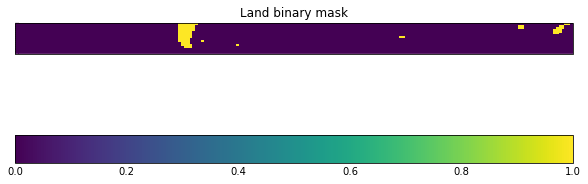

time: 261 ms (started: 2022-11-03 05:57:17 +00:00)


In [5]:
fig = plt.figure(figsize=[10,10])

qplt.pcolormesh(mask)

In [6]:
cubes = []

stashs = ['m01s02i300','m01s02i301','m01s02i302','m01s02i303','m01s02i285']

for i in tqdm(range(len(stashs))):

    cubes.append(iris.load_cube('mule-select-cr269a.pd2005*.pp', iris.AttributeConstraint(STASH=stashs[i])).\
    intersection(latitude = [-60,-40]))



100%|█████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:06<00:00, 13.22s/it]

time: 1min 6s (started: 2022-11-03 05:57:17 +00:00)


In [7]:
# is this the right index?
aod = sum(cubes)[2]

time: 84.7 ms (started: 2022-11-03 05:58:23 +00:00)


In [8]:
mask3d = np.broadcast_to(mask.data, aod.data.shape)
mask3d.shape

aod_masked = np.ma.masked_where(mask3d == 1, aod.data)

(365, 16, 192)

time: 6.83 s (started: 2022-11-03 05:58:23 +00:00)


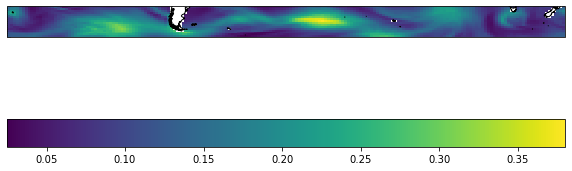

time: 564 ms (started: 2022-11-03 05:58:30 +00:00)


In [10]:
fig = plt.figure(figsize=[10,10])

ax = plt.subplot(1,1,1, projection = ccrs.PlateCarree())

plt.pcolormesh(aod[0].coord('longitude').points,
               aod[0].coord('latitude').points,
               aod_masked[0], transform = ccrs.PlateCarree())

plt.colorbar(orientation = 'horizontal')

ax.coastlines()

plt.show();

In [11]:
_1h_cell_method = iris.coords.CellMethod(
    method="mean", coords="time", intervals="1 hour"
)
_1h_cell_method_constraint = iris.Constraint(
    cube_func=lambda cube: _1h_cell_method in cube.cell_methods
)

wind = iris.load_cube('mule-select-cr269a.pd2005*.pp',
                      iris.AttributeConstraint(STASH='m01s03i227') &
                      _1h_cell_method_constraint).\
                      intersection(latitude = [-60,-40])

time: 22.2 s (started: 2022-11-03 05:58:30 +00:00)


In [12]:
wind_regridded = wind.regrid(mask, iris.analysis.Linear())

time: 4.27 ms (started: 2022-11-03 05:58:53 +00:00)


In [13]:
wind_regridded_masked = np.ma.masked_where(mask3d == 1, wind_regridded.data)

time: 1.5 s (started: 2022-11-03 05:58:53 +00:00)


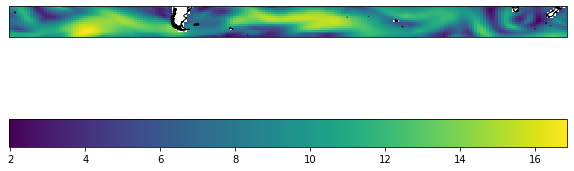

time: 138 ms (started: 2022-11-03 05:58:54 +00:00)


In [14]:
fig = plt.figure(figsize=[10,10])

ax = plt.subplot(1,1,1, projection = ccrs.PlateCarree())

plt.pcolormesh(wind_regridded[0].coord('longitude').points,
               wind_regridded[0].coord('latitude').points,
               wind_regridded_masked[0], transform = ccrs.PlateCarree())

plt.colorbar(orientation = 'horizontal')

ax.coastlines()

plt.show();

## make sure the arrays are the same shape

In [15]:
aod_masked[0].shape == wind_regridded_masked[0].shape

True

time: 2.18 ms (started: 2022-11-03 05:58:54 +00:00)


## scatter plot of all data

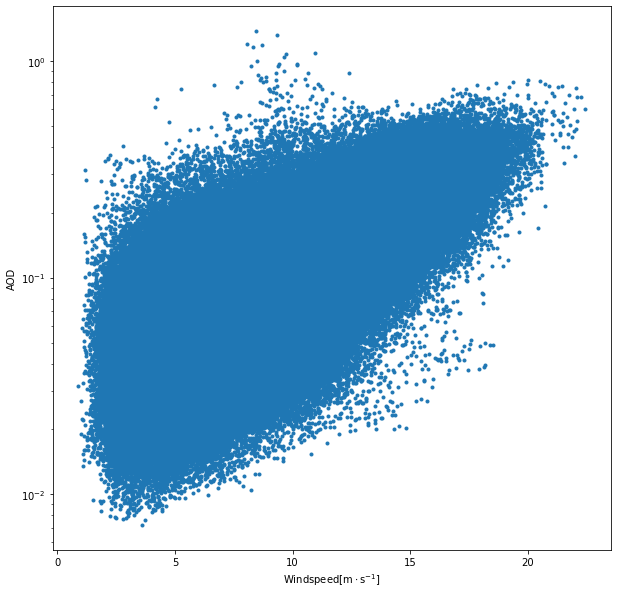

time: 1.23 s (started: 2022-11-03 05:58:54 +00:00)


In [16]:
fig = plt.figure(figsize=[10,10])

plt.scatter(wind_regridded_masked, aod_masked,marker = '.')

plt.yscale('log')
# plt.ylim([1e-3,2e0])
plt.xlabel(r'$\mathrm{Wind speed [m \cdot s^{-1}]}$')
plt.ylabel('AOD')

plt.show();

## now do integer windspeed bins

In [17]:
means = []
stds = []

bins = np.arange(1,21)

for i in tqdm(bins):
    means.append(aod_masked[np.logical_and(wind_regridded_masked > i, wind_regridded_masked < i+1)].mean())
    stds.append(aod_masked[np.logical_and(wind_regridded_masked > i, wind_regridded_masked < i+1)].std())
    
means = np.array(means)
stds = np.array(stds)

100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 69.11it/s]

time: 294 ms (started: 2022-11-03 05:58:56 +00:00)


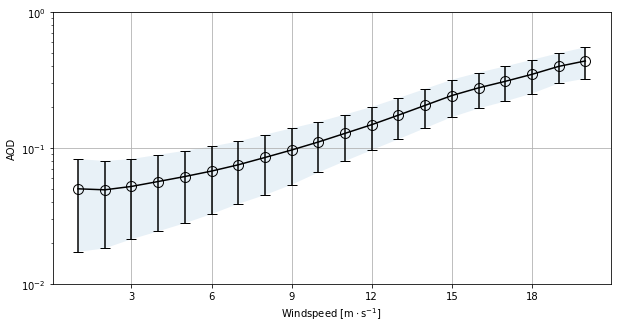

time: 236 ms (started: 2022-11-03 06:00:29 +00:00)


In [19]:
fig = plt.figure(figsize=[10,5])

ax = plt.subplot(1,1,1)

plt.errorbar(bins,means, yerr = stds, capsize = 5, marker = 'o', fillstyle = 'none', markersize = 10,
            color = 'k')

plt.fill_between(bins, means - stds, means + stds, alpha = 0.1)

plt.yscale('log')
plt.ylim([1e-2, 1e0])
plt.grid()
plt.xlabel(r'$\mathrm{Wind speed\ [m \cdot s^{-1}]}$')
plt.ylabel('AOD')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show();